In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import time

In [3]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [4]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_JF_ON = JF_file[channel_JFimages][:,:,:][reprate_laser]
        image_JF_OFF = JF_file[channel_JFimages][:,:,:][reprate_FEL]
        
        pulse_ids_ON = pulse_ids[reprate_laser]
        pulse_ids_OFF = pulse_ids[reprate_FEL]
        
        image_roi1_ON = image_JF_ON[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_ON = image_JF_ON[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
        image_roi1_OFF = image_JF_OFF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_OFF = image_JF_OFF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, pulse_ids_ON, pulse_ids_OFF

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]      
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy, Izero_pump, Izero_unpump

def LoadData_JF_crop(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids= jf_file["JF02T09V01_crop/pulse_ids"]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,)) # .ravel()
        
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_roi1_ON = JF_file["JF02T09V01_crop/roi1"][:,:,:][reprate_laser]
        image_roi1_OFF = JF_file["JF02T09V01_crop/roi1"][:,:,:][reprate_FEL]
        
        image_roi2_ON = JF_file["JF02T09V01_crop/roi2"][:,:,:][reprate_laser]
        image_roi2_OFF = JF_file["JF02T09V01_crop/roi2"][:,:,:][reprate_FEL]
        
        pulse_ids_ON = pulse_ids[reprate_laser]
        pulse_ids_OFF = pulse_ids[reprate_FEL]
    
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF, pulse_ids_ON, pulse_ids_OFF


In [5]:
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)

In [7]:
DIR = "/das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/"
DIR2 = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

!ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/


# DIR = "/das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop/"
# DIR2 = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/"
# DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

# !ls -lah -t /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop/
#!ls -lah -t /sf/alvra/data/p17803/raw/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)

print ("There are",number_files,"files in the folder", DIR)

total 11G
drwxrws---+  3 bacellar_c p17803 4.0K Feb 22 10:35 .
drwxrws---+ 23 cirelli_c  p17803  32K Feb 22 10:35 ..
drwxr-s---+  2 bacellar_c p17803 4.0K Feb 20 14:40 .ipynb_checkpoints
-rw-rw----+  1 bacellar_c p17803 535M Feb 19 20:35 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_00.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 19 15:31 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_04.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:24 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_20.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:20 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_19.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:15 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_18.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:11 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_17.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:06 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_16.h5
-rw-rw----+  1 bacellar_c p17803 535M Feb 10 13:02 CytC_Fe3_XES_timescan_5uJ_2

In [10]:
fileName = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_00.h5"

#fileName = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop_14.h5"


jf_file = h5py.File(DIR+fileName)
imageROI1 = jf_file["JF02T09V01_crop/roi1"]
imageROI2 = jf_file["JF02T09V01_crop/roi2"]
pulse_ids= jf_file["JF02T09V01_crop/pulse_ids"]
h5py.File.close

imageROI1.shape

(4000, 100, 200)

<IPython.core.display.Javascript object>


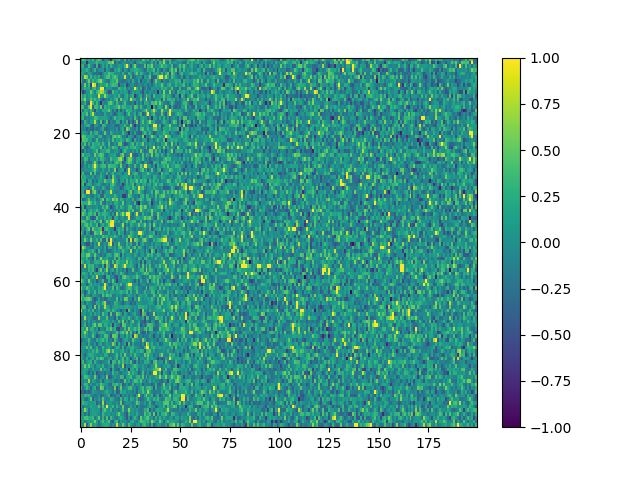

<IPython.core.display.Javascript object>


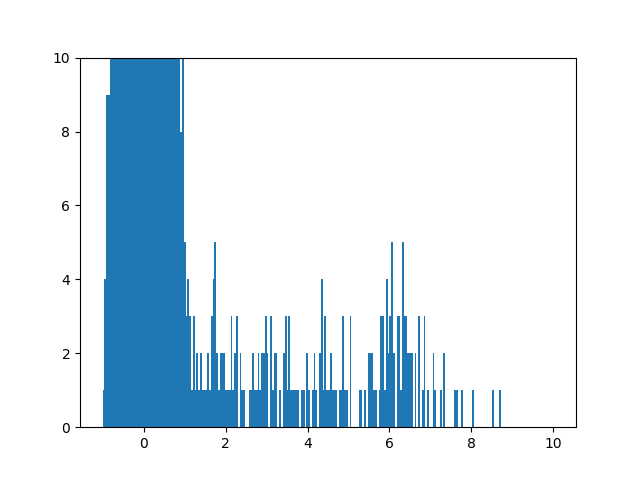

In [11]:
p=1
showfigure=imageROI1[p]
plt.figure()
plt.imshow(showfigure, aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

plt.figure()
plt.hist(showfigure.ravel(),250,[-1,10])
plt.ylim((0,10))
plt.show()


# Set Thresholds!

<IPython.core.display.Javascript object>


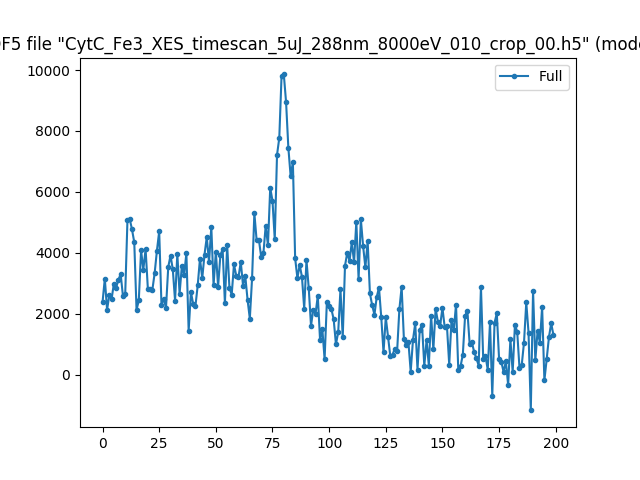

<IPython.core.display.Javascript object>


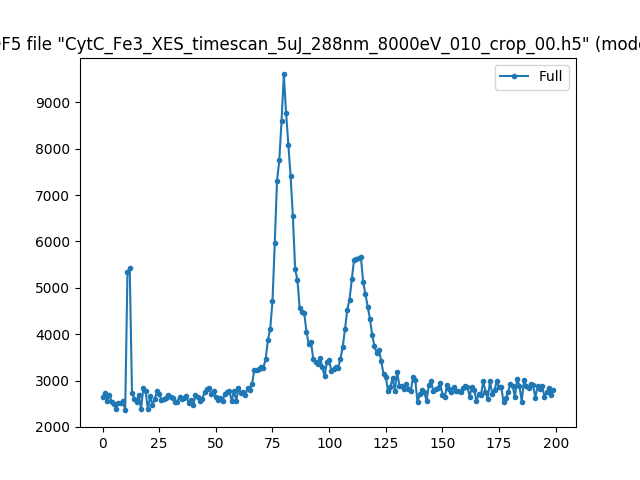

Text(0.5,1,'<HDF5 file "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_00.h5" (mode r+)>')

In [12]:
total=0
total_thr =0

threshold_low = 3
threshold_high = 7.5

nframes =1000
for i in range(nframes):
    image = imageROI1[i][:]
    image_thr = image
    total += image
    image_thr[image < threshold_low] = 0
    image_thr[image > threshold_high] = 0
    total_thr += image_thr

total_ave = total.sum(axis = 0)
plt.figure()
plt.plot(total_ave, label="Full", marker='.')
plt.legend(loc="best")
plt.title(jf_file)


total_avethr = total_thr.sum(axis = 0)
plt.figure()
plt.plot(total_avethr, label="Full", marker='.')
plt.legend(loc="best")
plt.title(jf_file)

<IPython.core.display.Javascript object>


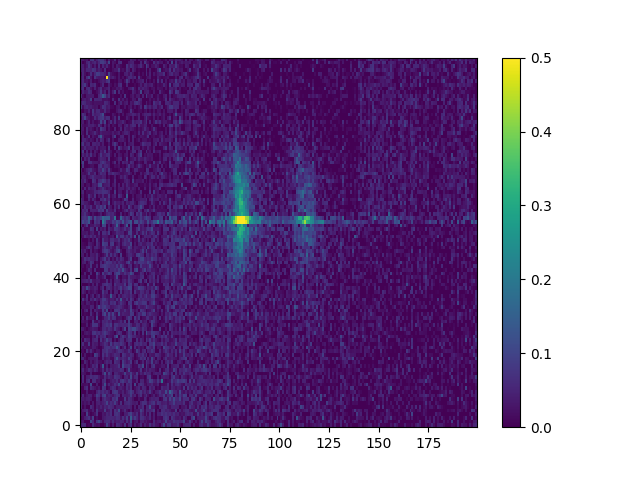

<IPython.core.display.Javascript object>


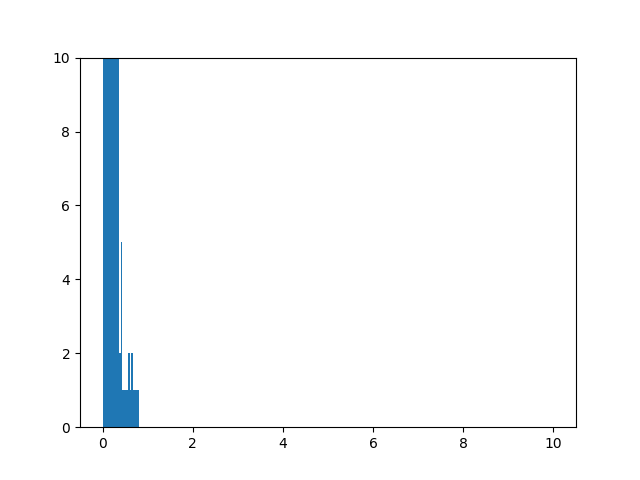

In [13]:
nframes = 2000
total=0

for i in range(nframes):
    image = imageROI1[i][:]
    total = total+image

total= total/nframes

plt.figure()
plt.imshow(total, origin="lower", aspect='auto', vmin=0.00, vmax=0.5)
plt.colorbar()
plt.show()

plt.figure()
plt.hist(total.ravel(),250,[0,10])
plt.ylim((0,10))
plt.show()

# Next cell is for a single file

In [14]:
threshold_low = 3.0
threshold_high = 7.0
sigma_low=1.1
sigma_high=5



files = ["CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010"]
#files = ["CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014"]

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
image_ON_2D_roi1=0
image_OFF_2D_roi1=0
        
for f in files:
    
    JF_single_file = DIR + f + "_crop_14.h5"
    BS_single_file = DIR2 + f + "_step0014.BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
    (image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF,pulse_ids_ON,pulse_ids_OFF) = LoadData_JF_crop(str(JF_single_file))
    (Delay_mm,Energy_eV,Izero_pump,Izero_unpump) = LoadData_BS(str(BS_single_file))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    nframes_ON = np.ma.size(image_roi1_ON,0)
    nframes_OFF = np.ma.size(image_roi1_OFF,0)
    print (nframes_ON, nframes_OFF)
    
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#         image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#         image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
#         image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
#         image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)/Izero_unpump[j]
        
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


Processing file /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_14.h5
2000 2000
Job done! It took 1.89 seconds to process 1 file(s)


<IPython.core.display.Javascript object>


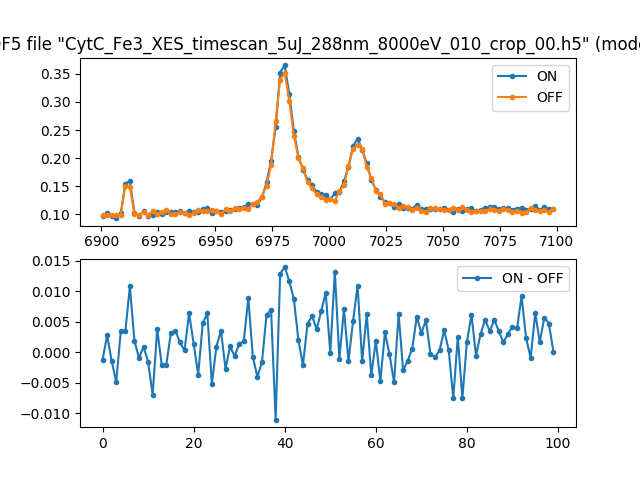

In [15]:
roi1 = [[200, 300], [6900, 7100]]

bin_ = 2   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
#plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

# Loop over the cropped files

In [16]:
threshold_low = 3.0
threshold_high = 7.5
sigma_low=1.1
sigma_high=5


scan_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010"
#scan_name = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014"
######################################################################################
start_time = time.time()
intermediate_time = time.time()


Energy_eV = []
Delay_mm = []
XAS_trans_roi1 = []
Error_XAS_roi1 = []
XAS_trans_roi2 = []
Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []

DIR = "/das/work/p17/p17803/alvra_beamline_scripts/"
DIR_crop = DIR + scan_name + "_crop/"

listfile_crop = os.listdir(DIR_crop)
numFiles_crop = len(listfile_crop)
print ("Number of cropped files:", numFiles_crop)

json_file = DIR_json + scan_name + "_scan_info.json"
with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
print ("Number of BS files:", numFiles)

#numFiles = 37

for i in range(0,numFiles):
    
    if i < 10:
        JF_crop_file = DIR_crop + scan_name + "_crop_0" + str(i) + ".h5"
    else:
        JF_crop_file = DIR_crop + scan_name + "_crop_" + str(i) + ".h5"   
    print ("step",i+1,"of",numFiles,": Processing", JF_crop_file)
    print ("Processing %s" % (str(data['scan_files'][i][0])))
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    image_ON_2D_roi1=0
    image_OFF_2D_roi1=0
    
    (image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF,pulse_ids_ON,pulse_ids_OFF) = LoadData_JF_crop(str(JF_crop_file))
    (delay_loop,energy_loop,Izero_pump,Izero_unpump) = LoadData_BS(str(data['scan_files'][i][0]))
    
    energy_loop = [x for x in energy_loop if (x > 0)]     #This is to prevent that some occasional zeros screw up the mean value calculated below
    delay_loop = [x for x in delay_loop if (x > 0)]       #This is to prevent that some occasional zeros screw up the mean value calculated below
    Delay_mm.append(np.mean(delay_loop))
    Energy_eV.append(np.mean(energy_loop))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    nframes_ON = np.ma.size(image_roi1_ON,0)
    nframes_OFF = np.ma.size(image_roi1_OFF,0)
    print (nframes_ON, nframes_OFF)
    
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#         image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#         image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
#         image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
#         image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)/Izero_unpump[j]
            
    spectrum_ON_roi1_baseline = spectrum_ON_roi1 - spectrum_ON_roi1[0:5:1].mean()
    spectrum_OFF_roi1_baseline = spectrum_OFF_roi1- spectrum_OFF_roi1[0:5:1].mean()
    difference_roi1 = (spectrum_ON_roi1_baseline - spectrum_OFF_roi1_baseline)
    #difference_roi1 = np.abs(difference_roi1)[70:95:1].sum()
    difference_roi1 = np.abs(difference_roi1)[75:85:1].sum()

    
    XAS_trans_roi1.append(difference_roi1)
    error_ON_roi1 = np.sum(np.sqrt(spectrum_ON_roi1))
    error_OFF_roi1 = np.sum(np.sqrt(spectrum_OFF_roi1))
    

    Error_XAS_roi1.append(np.sqrt(error_ON_roi1**2 + error_OFF_roi1**2))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt(np.sqrt(spectrum_ON_roi1)**2 + np.sqrt(spectrum_OFF_roi1)**2))
    
    difference_roi2 = spectrum_ON_roi2.sum() - spectrum_OFF_roi2.sum()
    XAS_trans_roi2.append(difference_roi2)
    error_ON_roi2 = np.sum(np.sqrt(spectrum_ON_roi2))
    error_OFF_roi2 = np.sum(np.sqrt(spectrum_OFF_roi2))
    
    Error_XAS_roi2.append(np.sqrt(error_ON_roi2**2 + error_OFF_roi2**2))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(difference_roi2)
    Error_transient_roi2.append(np.sqrt(np.sqrt(spectrum_ON_roi2)**2 + np.sqrt(spectrum_OFF_roi2)**2))
    
    print ("It took",round((time.time() - intermediate_time),2),"s to process this file")
    intermediate_time = time.time()
    
Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)

XAS_trans_roi1 = np.array(XAS_trans_roi1)
Error_XAS_roi1 = np.array(Error_XAS_roi1)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)

XAS_trans_roi2 = np.array(XAS_trans_roi2)
Error_XAS_roi2 = np.array(Error_XAS_roi2)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)

print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",numFiles,"file(s)")


Number of cropped files: 24
Number of BS files: 21
step 1 of 21 : Processing /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_00.h5
Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_step0000.BSREAD.h5
2000 2000
It took 1.83 s to process this file
step 2 of 21 : Processing /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_01.h5
Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_step0001.BSREAD.h5
2000 2000
It took 1.93 s to process this file
step 3 of 21 : Processing /das/work/p17/p17803/alvra_beamline_scripts/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_010_crop_02.h5
Processing /sf/alvra/data/p17803/raw/

<IPython.core.display.Javascript object>


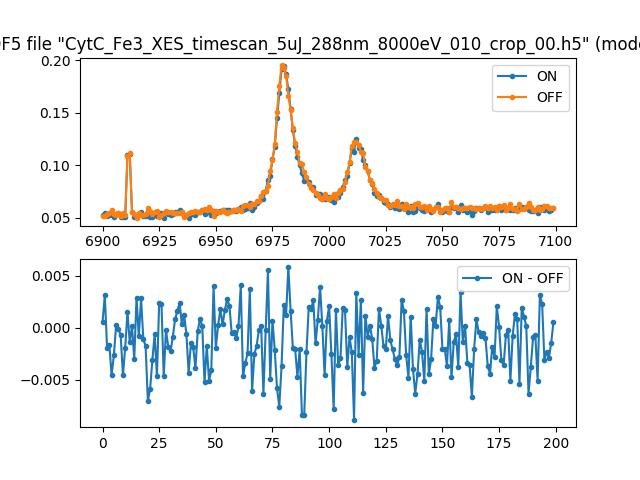

In [18]:
# Single file plot, to see whether it went ok, it would plot the last file of the loop above.
roi1 = [[200, 300], [6900, 7100]]

bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
#plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


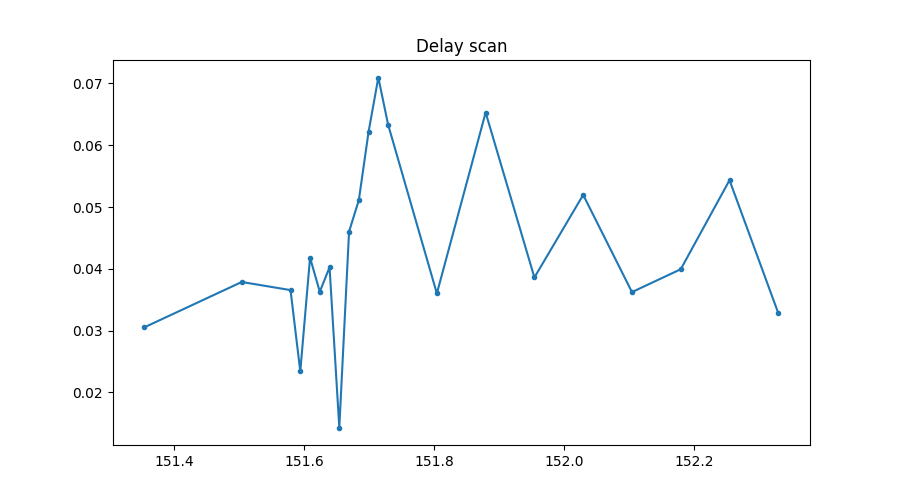

In [19]:
error_high = XAS_trans_roi1 + Error_XAS_roi1
error_low = XAS_trans_roi1 - Error_XAS_roi1

plt.figure(figsize=(9,5))
plt.title("Delay scan")
plt.plot(Delay_mm[0:len(XAS_trans_roi1)], XAS_trans_roi1,label="Delay scan",marker='.') #This is the meaningful plot if it is a delay scan
#plt.fill_between(np.squeeze(Delay_mm), error_low, error_high, color='lightblue')
plt.show()

In [17]:
scan_name='CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_011'

saveDir = "/das/work/p17/p17803/alvra_beamline_scripts/data_extract/"    # dest folder (needs to exist)
fn = str(saveDir + scan_name + "_processed_XES.h5")
hf.close()

hf = h5py.File(fn, 'w')
hf.create_dataset('Delay_mm', data=Delay_mm)
#hf.create_dataset('Delay_ps', data=Delay_ps)

# hf.create_dataset('t0', data=parameters[2])
# hf.create_dataset('rise', data=parameters[3])
# hf.create_dataset('a1', data=parameters[4])
# hf.create_dataset('t1', data=parameters[5])
# hf.create_dataset('a2', data=parameters[6])
# hf.create_dataset('t2', data=parameters[7])
# # 
# hf.create_dataset('Signal_pump', data=Signal_pump)
# hf.create_dataset('err_signal_pump', data=err_signal_pump)
# hf.create_dataset('Signal_unpump', data=Signal_unpump)
# hf.create_dataset('err_signal_unpump', data=err_signal_unpump)
hf.create_dataset('XAS_trans_roi1', data=XAS_trans_roi1)
hf.create_dataset('Error_transient_roi1', data=Error_transient_roi1)
hf.close()

In [18]:
def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [23]:
# Now fit with error funciton (defined above)
delay_ps = (Delay_mm - 151.65)*2/(3e8*1e3*1e-12)

#parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 150.193, 0.05]) # [baseline, step amplitude, center, FWHM]
parameters,extras = curve_fit(biexp, delay_ps, XAS_trans_roi1, p0 = [0.1, 0.1, 0, 0.2, 1, 0.7, 0.5, 10]) # [baseline, amplitude, t0, width, a1, t1, a2, t2]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"ps")
print("Width =",np.abs(np.round(parameters[3],3)),"ps")

Position t0 = 0.177 ps
Width = 0.031 ps


<IPython.core.display.Javascript object>


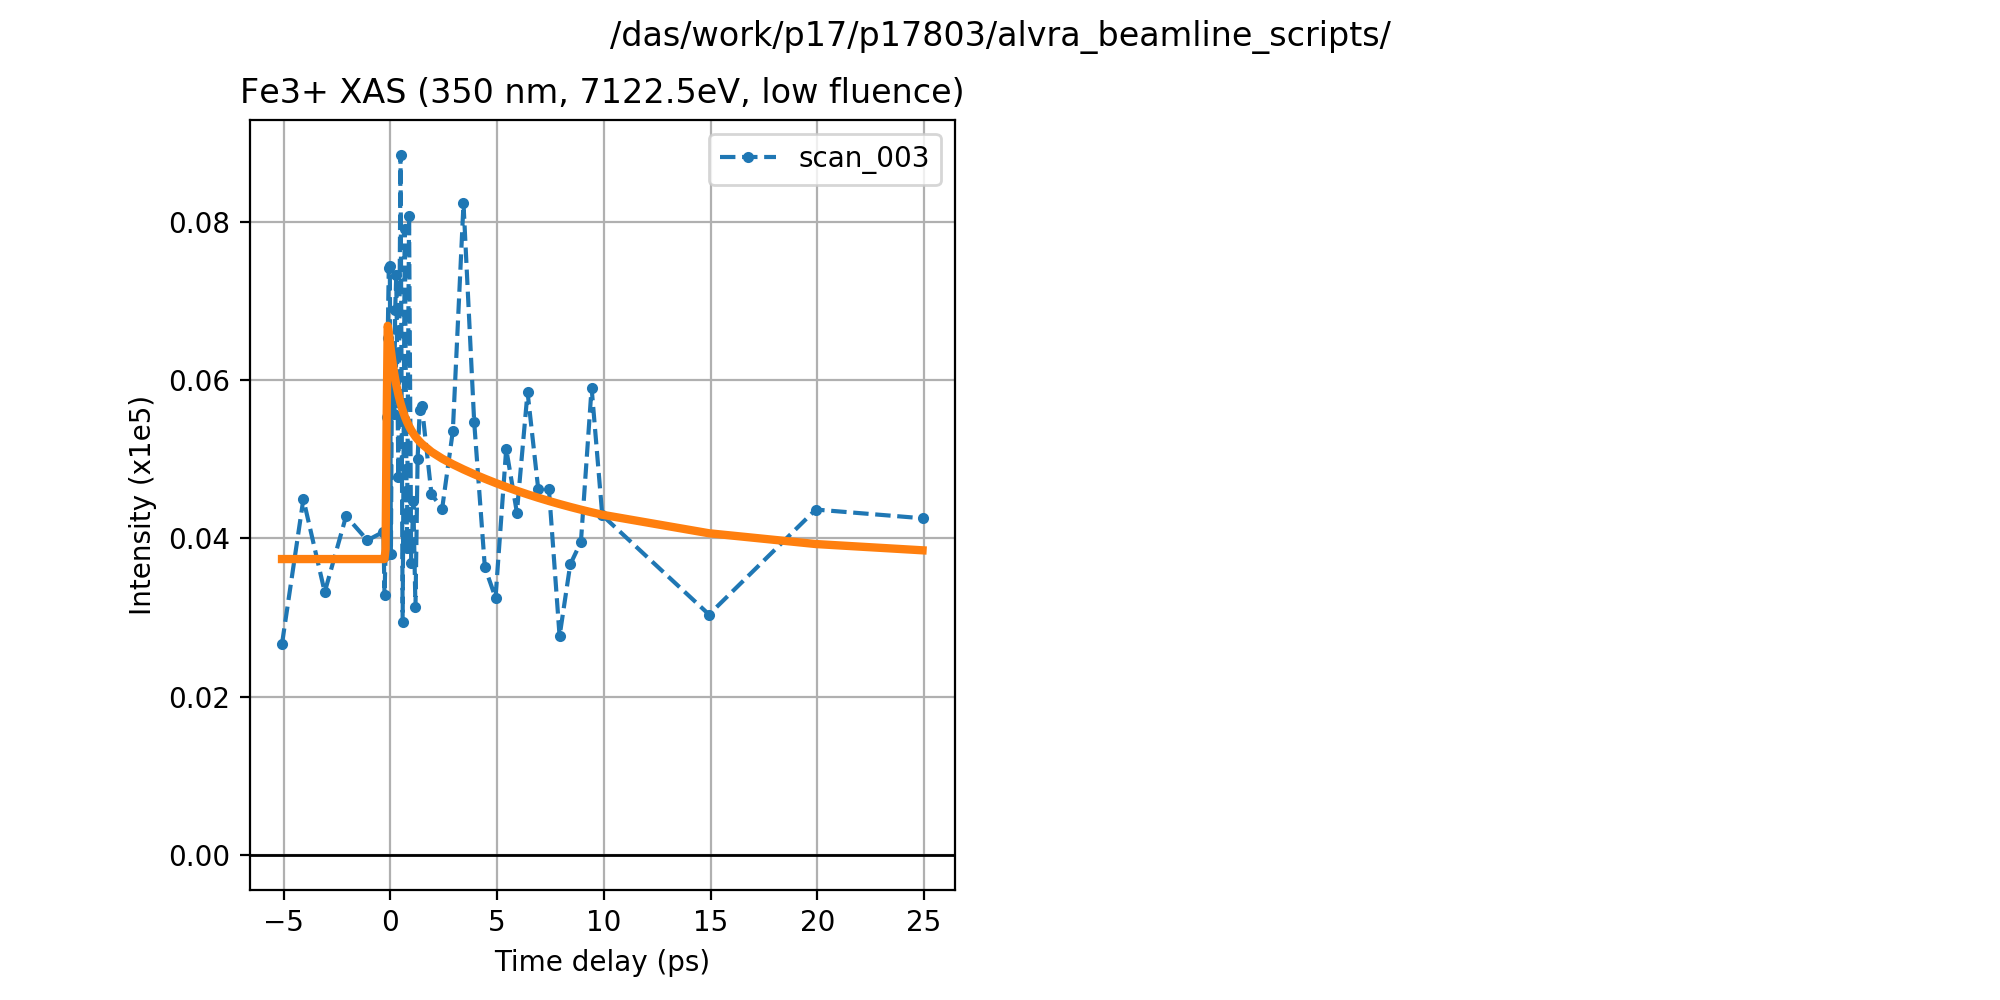

In [24]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)

plt.subplot(1,2,1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(delay_ps, XAS_trans_roi1,'--',label="scan_003",marker='.')
#plt.errorbar(Delay_ps, Signal_norm,yerr, fmt='o',label="scan_003",marker='.')
plt.plot(delay_ps, biexp(delay_ps,*parameters),linewidth=3)
plt.grid()
plt.xlabel("Time delay (ps)")
plt.ylabel("Intensity (x1e5)")
plt.gca().set_title('Fe3+ XAS (350 nm, 7122.5eV, low fluence)')
plt.legend(loc="best")
plt.show()
